# Quora Insincere Questions Classification

Competition [here](https://www.kaggle.com/c/quora-insincere-questions-classification/).

### Necessary imports

In [3]:
import pandas as pd
import itertools
import numpy as np
# import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, normalize

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import math
from scipy import stats
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
import seaborn as sns
%matplotlib inline

### Make behaviour deterministic and reproducable

In [96]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

### All keras related import

In [ ]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout, Layer, K
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, Callback

### Read the data provided by quora

In [3]:
d_train = pd.read_csv('data/train.csv')
d_test = pd.read_csv('data/test.csv')
d_sample = pd.read_csv('data/sample_submission.csv')

In [124]:
len(d_train)

1306122

## Explore the distrbution of the data

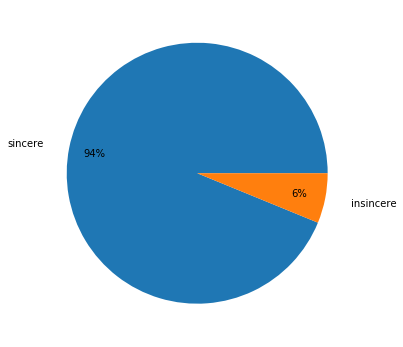

In [76]:
# ax = sns.countplot(x="target", data=d_train)
# ax.set_title('Class Distribution')
# plt.show()

classes = ['sincere', 'insincere']
fig = plt.figure(figsize=(6,6))

# def show_distribution(y)
c = Counter(d_train['target'])
counts = [0, 0]
for k, count in c.items():
    counts[k] = count

ax = plt.pie(counts, labels=classes, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.2)
plt.show()

In [146]:
d_train[d_train.target == 0].shape

(1225312, 3)

## Split the Quora provided training set into a training and validation segment

In [25]:
df_train, df_val = train_test_split(d_train, 
                                   stratify=d_train['target'], 
                                   random_state=42, 
                                   test_size=0.5, shuffle=True)

### Required NLTK downloads

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asifiqbal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asifiqbal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asifiqbal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Define utility method for text tokenization and normalization 

In [26]:
ls = LancasterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def lexicon_normalize(text):
    words = word_tokenize(text) 
    words = [w for w in words if not w in stop_words]
    
    # 1- Stemming
#     words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
#     words_lem = [lem.lemmatize(w) for w in words_stem]
    return ' '.join(words)

In [27]:
df_train['question_text'] = df_train['question_text'].apply(lexicon_normalize)
df_val['question_text'] = df_val['question_text'].apply(lexicon_normalize)

/Users/asifiqbal/Development/anaconda/anaconda3/envs/asif_keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/asifiqbal/Development/anaconda/anaconda3/envs/asif_keras/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
df_train.head(5)

,qid,question_text,target
130809,1997303f75a0257279d3,Why become data science manager stop individua...,0
36523,0724e0ed554a08117e30,Is true Mexicans treated like second class cit...,0
1109227,d95ba7dbe88b1288cdfe,Why I see psychiatrist related ?,0
349685,4488308d81ce3ee7a7da,Why China want capture countries ?,0
341120,42d2135f36b1f8bec9ed,What best patient interaction doctor ?,0


### Prepare the training, validation and test data sets. We prepare 3 training and 3 validation sets here.

- First training set has sincere:insincere ratio as the true distribution (94:6)
- Second training est has sincere:insincere ratio as 1:1
- Third training est has sincere:insincere ratio as 2:1
- Validation and test datasets have sincere:insincere ratio as the true distribution (94:6)

In [29]:
n = len(df_train)

# prepare train sets
df_train1, df_train2, df_train3 = df_train[:math.ceil(n/3)], \
                                   df_train[math.ceil(n/3):math.ceil(2 * n/3)], \
                                   df_train[math.ceil(2 * n/3):]

df_train1, _ = train_test_split(df_train1, 
                              stratify=df_train1['target'], 
                              random_state=42, 
                              train_size=0.1, shuffle=True)

df_train2 = pd.concat([df_train2[df_train2['target'] == 0].sample(n=10884, random_state=42),
                     df_train2[df_train2['target'] == 1].sample(n=10884, random_state=42)])

df_train3 = pd.concat([df_train3[df_train3['target'] == 0].sample(n=14512, random_state=42),
                     df_train3[df_train3['target'] == 1].sample(n=7256, random_state=42)])


x_train_sets = [df_train1['question_text'], df_train2['question_text'], 
                df_train3['question_text']]

y_train_sets = [df_train1['target'], df_train2['target'], 
                df_train3['target']]

# prepare validation sets

x_val_sets = []
y_val_sets = []

n = len(df_val)

for i in range(3):
    val_set = df_val[math.ceil(i * n/5):math.ceil((i + 1) * n/5)]
    val_set = val_set.sample(frac=0.04)
    x_val_sets.append(val_set['question_text'])
    y_val_sets.append(val_set['target'])

/Users/asifiqbal/Development/anaconda/anaconda3/envs/asif_keras/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [82]:
df_test_own.shape

(52245, 100)

In [55]:
df_test_own = df_val[math.ceil(3 * n/5):n]
df_test_own = df_test_own.sample(frac=0.2)

In [84]:
len(word_index)

139962

In [56]:
df_test_own.shape

(52245, 3)

### Utility method for plotting confusion matrix

In [32]:
classes = ['sincere', 'insincere']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return cm

## Pre-experimentation with Logistic Regression

### TF-IDF vectors

In [112]:
tf_idf_vectorizer = TfidfVectorizer(min_df=3, max_features=None, 
                                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                                stop_words = 'english')  

tf_idf_vectorizer.fit(list(df_train['question_text']))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words='english', strip_accents='unicode', sublinear_tf=1,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

In [131]:
def logreg_evaluate(x_train, x_val, y_train, y_val, vectorizer, train_index, val_index):
    x_train_vectorized = vectorizer.transform(x_train)
    x_val_vectorized = vectorizer.transform(x_val)
    
    logreg_model = LogisticRegression(C=1.0)
    logreg_model.fit(x_train_vectorized, y_train)
    logreg_score = logreg_model.score(x_val_vectorized, y_val)
    logreg_pred = logreg_model.predict(x_val_vectorized)
    
    cnf_matrix = confusion_matrix(y_val, logreg_pred)
#     plot_confusion_matrix(cnf_matrix, classes)
#     print(classification_report(y_val, logreg_pred, target_names=classes))
    f1 = f1_score(y_val, logreg_pred)
    print('Training Set {}, Validation Set {}, F1: {}'.format(train_index, val_index, f1))
    return logreg_pred
    

### Evaluate logistic regression model with TF-IDF

In [134]:
preds = []
for i in range(3):
    for j in range(3):
        pred = logreg_evaluate(x_train_sets[i], x_val_sets[j], y_train_sets[i], y_val_sets[j], 
                               tf_idf_vectorizer, i, j)
        if j == 0:
            preds.append(pred)

Training Set 0, Validation Set 0, F1: 0.08602150537634409
Training Set 0, Validation Set 1, F1: 0.03858520900321543
Training Set 0, Validation Set 2, F1: 0.04347826086956522
Training Set 1, Validation Set 0, F1: 0.4656669297553275
Training Set 1, Validation Set 1, F1: 0.44265232974910385
Training Set 1, Validation Set 2, F1: 0.41512469831053905
Training Set 2, Validation Set 0, F1: 0.5111371629542791
Training Set 2, Validation Set 1, F1: 0.5256241787122208
Training Set 2, Validation Set 2, F1: 0.4878048780487806


In [115]:
m = stats.mode(preds)
fpreds = m.mode[0]
print(classification_report(y_val_sets[0], fpreds, target_names=classes))

              precision    recall  f1-score   support

     sincere       0.97      0.94      0.96      4874
   insincere       0.44      0.62      0.51       351

   micro avg       0.92      0.92      0.92      5225
   macro avg       0.71      0.78      0.74      5225
weighted avg       0.94      0.92      0.93      5225



### Word count vectors

In [117]:
count_vectorizer = CountVectorizer(min_df=3, max_features=None, 
                                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), stop_words = 'english')  

count_vectorizer.fit(list(df_train['question_text']))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

### Evaluate logistic regression model with Word count vectors

In [135]:
preds = []
for i in range(3):
    for j in range(3):
        pred = logreg_evaluate(x_train_sets[i], x_val_sets[j], y_train_sets[i], y_val_sets[j], 
                               count_vectorizer, i, j)
        if j == 0:
            preds.append(pred)

Training Set 0, Validation Set 0, F1: 0.32618025751072965
Training Set 0, Validation Set 1, F1: 0.35748792270531404
Training Set 0, Validation Set 2, F1: 0.3589743589743589
Training Set 1, Validation Set 0, F1: 0.49228130360205835
Training Set 1, Validation Set 1, F1: 0.4793863854266539
Training Set 1, Validation Set 2, F1: 0.45739130434782604
Training Set 2, Validation Set 0, F1: 0.5648351648351648
Training Set 2, Validation Set 1, F1: 0.5315533980582524
Training Set 2, Validation Set 2, F1: 0.5146726862302483


In [170]:
# preds = logreg_model.predict(x_test_count)
# df_submission = pd.DataFrame({'qid': test.qid, 'prediction': preds})
# df_submission.to_csv('submission_quora.csv',header=True, index=False)

## Experimentation with LSTM and Capsule models 

### Word embedding

In [35]:
embeddings_index = {}
with open('data/glove.840B.300d.txt') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:40, 9959.26it/s] 

Found 2196016 word vectors.


### Use keras tokenizer for constructing word index matrix.
Every word at this stage is a (maximum word_index + 1) dimensional vector

In [36]:
max_len = 100
# using keras tokenizer here
tokenizer = text.Tokenizer(num_words=None)
# df_train['question_text'] = df_train['question_text'].apply(lexicon_normalize)
tokenizer.fit_on_texts(df_train['question_text'])
word_index = tokenizer.word_index

### Construct an emebdding matrix

Maps every word from a (maximum word_index + 1) dimensional vector to a 300 dmensional vector

In [37]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Utility methods for capsule layers.

Code taken from [here](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-capsule-networks).

In [38]:
routings = 5
num_capsule = 10
dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

### Utility methods for data pre-processing, model building and evaluation.

In [39]:
def pre_process_data(data):
    data = tokenizer.texts_to_sequences(data)
    
    # zero pad the sequences
    data = sequence.pad_sequences(data, maxlen=max_len)
    return data

def get_preprocessed_data(x_train_sets, x_val_sets):
    train = []
    val = []
    for s in x_train_sets:
        train.append(pre_process_data(s))
    for s in x_val_sets:
        val.append(pre_process_data(s))  
    return train, val
    
def get_lstm_model(bidirectional=True, dropout=0.3):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    if bidirectional:
        model.add(Bidirectional(LSTM(100, dropout=dropout, recurrent_dropout=dropout)))
    else:
        model.add(LSTM(100, dropout=dropout, recurrent_dropout=0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def get_lstm_model_with_capsule(bidirectional=True, dropout=0.3):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    if bidirectional:
        model.add(Bidirectional(LSTM(100, dropout=dropout, recurrent_dropout=dropout, return_sequences=True)))
    else:
        model.add(LSTM(100, dropout=dropout, recurrent_dropout=dropout, return_sequences=True))

    model.add(Capsule(num_capsule=num_capsule, dim_capsule=dim_capsule, routings=routings,
                      share_weights=True))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

class MetricsCallback(Callback):
    def __init__(self, x_train, y_train, x_val_sets, y_val_sets):
        self.x_val_sets = x_val_sets
        self.y_val_sets = y_val_sets
        self.x_train = x_train
        self.y_train = y_train
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        preds = self.model.predict_classes(self.x_train)
        preds = preds.reshape((preds.shape[0],))
        f1 = f1_score(self.y_train, preds)
        self.train_f1_scores.append(f1)
        print('Training set F1 score (for insincere class): {}'.format(f1))
        val_epoch_f1_scores = []
        for i, (x, y) in enumerate(zip(self.x_val_sets, self.y_val_sets)):
#             loss, acc = self.model.evaluate(x, y, verbose=0)
            preds = self.model.predict_classes(x)
            preds = preds.reshape((preds.shape[0],))
            f1 = f1_score(y, preds)
            val_epoch_f1_scores.append(f1)
#             print('Validation set {} loss: {}, acc: {}\n'.format(i, loss, acc))
            print('Validation set {} F1 score (for insincere class): {}'.format(i, f1))
        self.val_f1_scores.append(val_epoch_f1_scores)

def evaluate(x_train, y_train, x_vals, y_vals, model):
    metrics_callback = MetricsCallback(x_train, y_train, x_vals, y_vals)
    history = model.fit(x_train, y=y_train, batch_size=32, 
                        epochs=10, verbose=1,
                        callbacks=[metrics_callback])
    
    return model, metrics_callback.train_f1_scores, metrics_callback.val_f1_scores

### Prepare the training and validation sets for feeding into the neural models.

In [40]:
x_train_sets_prep, x_val_sets_prep = get_preprocessed_data(x_train_sets, x_val_sets)

### Fit the LSTM-only models on all 3 training data sets and evaluate each of them on all 3 validation sets

In [41]:
lstm_models = []
f1_train_history_lstms = []
f1_vals_history_lstms = []

for i in range(len(x_train_sets_prep)):
    model, f1_train_history_lstm, f1_vals_history_lstm = evaluate(x_train_sets_prep[i], 
                                                                y_train_sets[i], 
                                                                x_val_sets_prep, 
                                                                y_val_sets,
                                                                get_lstm_model(dropout=0.3))
    lstm_models.append(model)
    f1_train_history_lstms.append(f1_train_history_lstm)
    f1_vals_history_lstms.append(f1_vals_history_lstm)

Epoch 1/10
21768/21768 [==============================] - 114s 5ms/step - loss: 0.1690 - acc: 0.9398
Training set F1 score (for insincere class): 0.5126811594202898
Validation set 0 F1 score (for insincere class): 0.4869888475836431
Validation set 1 F1 score (for insincere class): 0.4845995893223819
Validation set 2 F1 score (for insincere class): 0.4609375
Epoch 2/10
21768/21768 [==============================] - 100s 5ms/step - loss: 0.1440 - acc: 0.9463
Training set F1 score (for insincere class): 0.591800356506239
Validation set 0 F1 score (for insincere class): 0.5916870415647922
Validation set 1 F1 score (for insincere class): 0.5726256983240223
Validation set 2 F1 score (for insincere class): 0.5358024691358024
Epoch 3/10
21768/21768 [==============================] - 101s 5ms/step - loss: 0.1367 - acc: 0.9480
Training set F1 score (for insincere class): 0.6116760828625236
Validation set 0 F1 score (for insincere class): 0.5957446808510638
Validation set 1 F1 score (for insincer

Training set F1 score (for insincere class): 0.850206079340546
Validation set 0 F1 score (for insincere class): 0.49062500000000003
Validation set 1 F1 score (for insincere class): 0.48251121076233183
Validation set 2 F1 score (for insincere class): 0.44891640866873056
Epoch 4/10
21768/21768 [==============================] - 104s 5ms/step - loss: 0.2822 - acc: 0.8873
Training set F1 score (for insincere class): 0.8607192529306578
Validation set 0 F1 score (for insincere class): 0.5341400172860847
Validation set 1 F1 score (for insincere class): 0.5365853658536585
Validation set 2 F1 score (for insincere class): 0.4896193771626297
Epoch 5/10
21768/21768 [==============================] - 104s 5ms/step - loss: 0.2694 - acc: 0.8921
Training set F1 score (for insincere class): 0.8671978751660026
Validation set 0 F1 score (for insincere class): 0.531951640759931
Validation set 1 F1 score (for insincere class): 0.5270541082164328
Validation set 2 F1 score (for insincere class): 0.4905008635

In [42]:
f1_train_history_lstms = np.array(f1_train_history_lstms)
f1_vals_history_lstms = np.array(f1_vals_history_lstms)

### Utility method for getting final max-voted F1 scores from all 3 models

In [43]:
def get_final_scores(models):
    final_preds = []
    f1_scores = []
    for i in range(len(x_val_sets_prep)):
        preds = []
        for j in range(len(x_train_sets_prep)):
            pred = models[j].predict_classes(x_val_sets_prep[i])
            pred = pred.reshape((pred.shape[0],))
            preds.append(pred)
        m = stats.mode(preds)
        final_pred = m.mode[0]
        final_preds.append(final_pred)
        f1_final = f1_score(y_val_sets[i], final_pred)
        f1_scores.append(f1_final)
    return f1_scores, final_preds

In [44]:
f1_scores_lstm, final_preds_lstm = get_final_scores(lstm_models)

### Plot the training and validation F1 scores trends for LSTM-only models

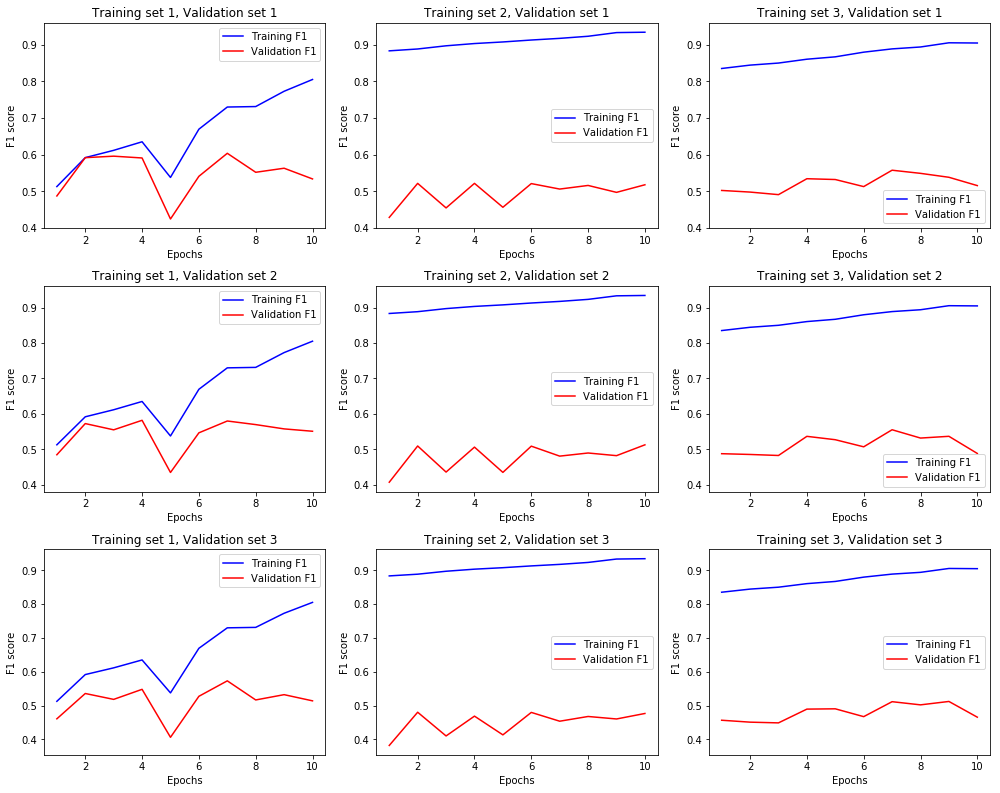

In [94]:
epochs = range(1, 10 + 1)

fig = plt.figure(figsize=(14, 18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.30, wspace=0.40) 
c = 1
for i in range(3):
    for j in range(3):       
        if j == 0:
            ax = fig.add_subplot(5, 3, c)
            sharedax = ax
        else:
            ax = fig.add_subplot(5, 3, c, sharey=sharedax)
        ax.plot(epochs, f1_train_history_lstms[j], 'b', label='Training F1')
        ax.plot(epochs, f1_vals_history_lstms[j][:, i], 'r', label='Validation F1')
        ax.set_title('Training and validation f1 scores')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('F1 score')
        ax.legend()
        ax.set_title('Training set {}, Validation set {}'.format(j + 1, i + 1))
        c += 1
plt.tight_layout()
plt.savefig('exp1')

### Print out best epoch performance for LSTM-only models

In [104]:
for i, history in enumerate(f1_vals_history_lstms):
    sum_recall = history.sum(axis=1)
    best_epoch = sum_recall.argmax()
    print('Best validation performance found on epoch {} for training set {}'.format(best_epoch + 1, i + 1))
    print('Epoch {} validation scores: {}'.format(best_epoch, history[best_epoch]))

Best validation performance found on epoch 7 for training set 1
Epoch 6 validation scores: [0.6036036  0.57990115 0.57322835]
Best validation performance found on epoch 2 for training set 2
Epoch 1 validation scores: [0.52144659 0.5093412  0.48040886]
Best validation performance found on epoch 7 for training set 3
Epoch 6 validation scores: [0.55737705 0.55519829 0.5115848 ]


### Fit the LSTM with Capsule models on all 3 training data sets and evaluate each of them on all 3 validation sets


In [46]:
capsule_models = []
f1_train_history_capsules = []
f1_vals_history_capsules = []

for i in range(len(x_train_sets_prep)):
    model, f1_train_history_capsule, f1_vals_history_capsule = evaluate(x_train_sets_prep[i], 
                                                            y_train_sets[i], 
                                                            x_val_sets_prep, 
                                                            y_val_sets,
                                                            get_lstm_model_with_capsule(dropout=0.3))
    capsule_models.append(model)
    f1_train_history_capsules.append(f1_train_history_capsule)
    f1_vals_history_capsules.append(f1_vals_history_capsule)

Epoch 1/10
21768/21768 [==============================] - 129s 6ms/step - loss: 0.1646 - acc: 0.9420
Training set F1 score (for insincere class): 0.4841906559697971
Validation set 0 F1 score (for insincere class): 0.4868913857677903
Validation set 1 F1 score (for insincere class): 0.4658119658119658
Validation set 2 F1 score (for insincere class): 0.42828282828282827
Epoch 2/10
21768/21768 [==============================] - 126s 6ms/step - loss: 0.1484 - acc: 0.9440
Training set F1 score (for insincere class): 0.5725925925925925
Validation set 0 F1 score (for insincere class): 0.5601217656012177
Validation set 1 F1 score (for insincere class): 0.5534804753820034
Validation set 2 F1 score (for insincere class): 0.4944881889763779
Epoch 3/10
21768/21768 [==============================] - 126s 6ms/step - loss: 0.1514 - acc: 0.9427
Training set F1 score (for insincere class): 0.3271028037383178
Validation set 0 F1 score (for insincere class): 0.25233644859813087
Validation set 1 F1 score (

In [47]:
f1_scores_capsule, final_preds_capsules = get_final_scores(capsule_models)

In [48]:
f1_train_history_capsules = np.array(f1_train_history_capsules)
f1_vals_history_capsules = np.array(f1_vals_history_capsules)

### Plot the training and validation F1 scores trends for LSTM with Capsule models

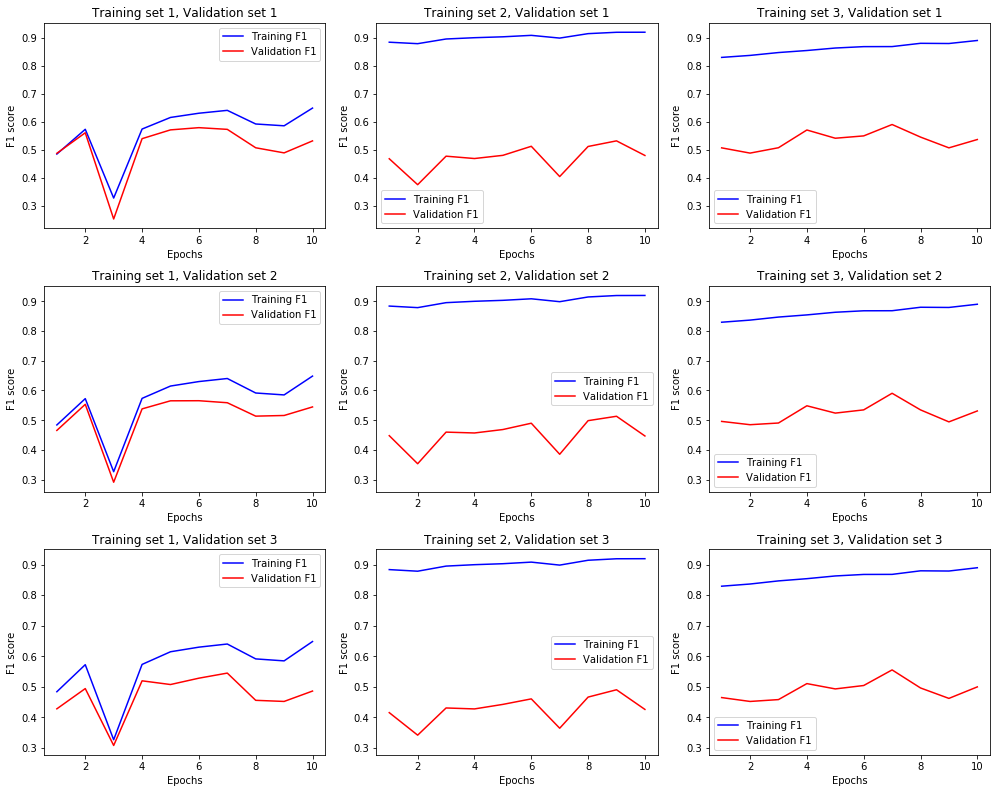

In [157]:
epochs = range(1, 10 + 1)

fig = plt.figure(figsize=(14, 18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.30, wspace=0.40) 
c = 1
for i in range(3):
    for j in range(3):       
        if j == 0:
            ax = fig.add_subplot(5, 3, c)
            sharedax = ax
        else:
            ax = fig.add_subplot(5, 3, c, sharey=sharedax)
        ax.plot(epochs, f1_train_history_capsules[j], 'b', label='Training F1')
        ax.plot(epochs, f1_vals_history_capsules[j][:, i], 'r', label='Validation F1')
        ax.set_title('Training and validation f1 scores')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('F1 score')
        ax.legend()
        ax.set_title('Training set {}, Validation set {}'.format(j + 1, i + 1))
        c += 1
plt.tight_layout()
plt.savefig('exp2')

### Print out best epoch performance for LSTM with Capsule models

In [109]:
for i, history in enumerate(f1_vals_history_capsules):
    sum_recall = history.sum(axis=1)
    best_epoch = sum_recall.argmax()
    print('Best validation performance found on epoch {} for training set {}'.format(best_epoch + 1, i + 1))
    print('Epoch {} validation scores: {}'.format(best_epoch, history[best_epoch]))

Best validation performance found on epoch 7 for training set 1
Epoch 6 validation scores: [0.57235772 0.55882353 0.54513889]
Best validation performance found on epoch 9 for training set 2
Epoch 8 validation scores: [0.53127678 0.51335878 0.49063032]
Best validation performance found on epoch 7 for training set 3
Epoch 6 validation scores: [0.58966565 0.59063625 0.55555556]


### Check the final (after 10 epochs) F1 scores for LSTM and Capsule models

In [700]:
f1_scores_capsule

[0.49079754601226994,
 0.5063291139240506,
 0.49147982062780277,
 0.4896421845574388,
 0.4911347517730497]

In [701]:
f1_scores_lstm

[0.5425425425425425,
 0.5380710659898477,
 0.5356415478615071,
 0.5249734325185973,
 0.5371312309257376]

## Evaluate F1 score performance on our own test data with LSTM-only models

In [63]:
df_test_y = df_test_own['target']
df_test_own = df_test_own['question_text'].apply(lexicon_normalize)
df_test_own = pre_process_data(df_test_own)

              precision    recall  f1-score   support

     sincere       0.99      0.91      0.95     48922
   insincere       0.39      0.88      0.55      3323

   micro avg       0.91      0.91      0.91     52245
   macro avg       0.69      0.90      0.75     52245
weighted avg       0.95      0.91      0.92     52245

Normalized confusion matrix


array([[0.90785332, 0.09214668],
       [0.1152573 , 0.8847427 ]])

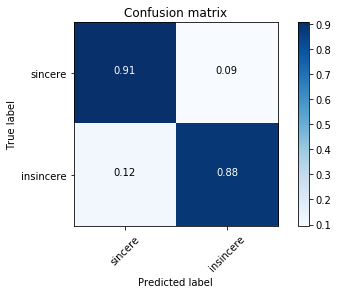

In [143]:
test_preds = []
for model in lstm_models:
    test_pred = model.predict_classes(df_test_own)
    test_pred = test_pred.reshape((test_pred.shape[0],))
    test_preds.append(test_pred)
m = stats.mode(test_preds)
final_test_pred = m.mode[0]

print(classification_report(df_test_y, final_test_pred, target_names=classes))
cnf_matrix = confusion_matrix(df_test_y, final_test_pred)
plot_confusion_matrix(cnf_matrix, classes, normalize=True)

Confusion matrix, without normalization


array([[44414,  4508],
       [  383,  2940]])

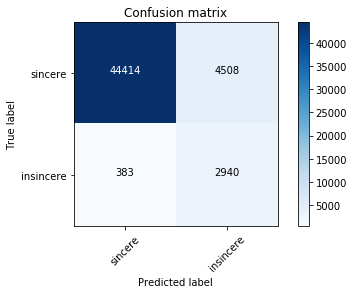

In [144]:
plot_confusion_matrix(cnf_matrix, classes, normalize=False)

## Final F1 score with LSTM only model

In [66]:
f1 = f1_score(df_test_y, final_test_pred)
f1

0.5480406932931424

## Evaluate F1 score performance on our own test data with LSTM with Capsule models

              precision    recall  f1-score   support

     sincere       0.99      0.91      0.95     48922
   insincere       0.39      0.88      0.55      3323

   micro avg       0.91      0.91      0.91     52245
   macro avg       0.69      0.90      0.75     52245
weighted avg       0.95      0.91      0.92     52245

Normalized confusion matrix


array([[0.90785332, 0.09214668],
       [0.1152573 , 0.8847427 ]])

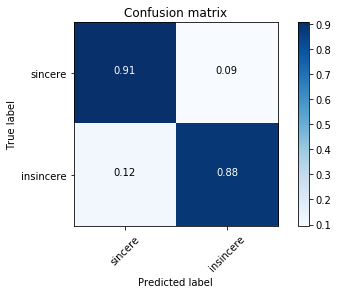

In [140]:
test_preds = []
for model in capsule_models:
    test_pred = model.predict_classes(df_test_own)
    test_pred = test_pred.reshape((test_pred.shape[0],))
    test_preds.append(test_pred)
m = stats.mode(test_preds)
final_test_pred = m.mode[0]

print(classification_report(df_test_y, final_test_pred, target_names=classes))
cnf_matrix = confusion_matrix(df_test_y, final_test_pred)
plot_confusion_matrix(cnf_matrix, classes, normalize=True)

Confusion matrix, without normalization


array([[44414,  4508],
       [  383,  2940]])

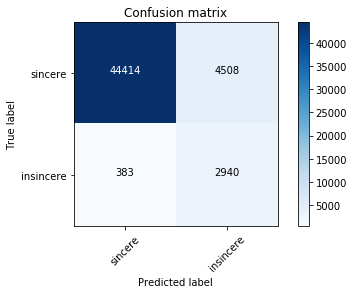

In [145]:
plot_confusion_matrix(cnf_matrix, classes, normalize=False)

## Final F1 score with LSTM with Capsule model


In [141]:
f1 = f1_score(df_test_y, final_test_pred)
f1

0.545910314734008

## Finally, prepare submission file for evaluating our models on Kaggle's actual test data

In [149]:
df_test = d_test['question_text']

In [150]:
df_test= df_test.apply(lexicon_normalize)

In [151]:
df_test = pre_process_data(df_test)

In [152]:
test_preds = []
for model in capsule_models:
    test_pred = model.predict_classes(df_test)
    test_pred = test_pred.reshape((test_pred.shape[0],))
    test_preds.append(test_pred)
m = stats.mode(test_preds)
final_kaggle_test_pred = m.mode[0]

df_submission = pd.DataFrame({'qid': d_test.qid, 'prediction': final_kaggle_test_pred})
df_submission.to_csv('submission.csv',header=True, index=False)